In [1]:
from py_extrema.extrema import ExtremaFinder
from py_extrema.slopping_saddle import SloppingSaddle

from cycler import cycler

%pylab
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
from mpl_toolkits.mplot3d import Axes3D

/home/ccc/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Let us first generate a Gaussian random field in 2D with a power law power spectrum with slope $n_s = -1$.

In [2]:
mu = np.random.standard_normal((1024, 1024))
muk = np.fft.rfftn(mu)

kgrid = np.c_[np.meshgrid(*[np.fft.fftfreq(_) for _ in mu.shape[:-1]], np.fft.rfftfreq(mu.shape[-1]), indexing='ij')]
k = np.linalg.norm(kgrid, axis=0)
Pk = np.zeros_like(k)
Pk[k>0] = k[k>0]**-1

deltak = muk * np.sqrt(Pk)
delta = np.fft.irfftn(deltak)

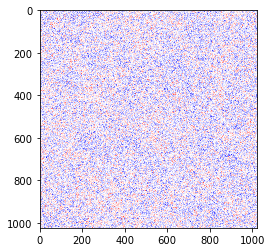

In [3]:
plt.imshow(delta, cmap='bwr')

# Extracting extrema from the field

Build the extrema finder.

In [4]:
ef = ExtremaFinder(delta, cache_len=1, nthreads=4, boxlen=100)

Using `ef.smooth`, we can easily get a smoothed version of the field. Note that the argument is in the same unit as `boxlen`, so that `ef.smooth(100)` will smooth with a Gaussian filter of the size of the box (that's a bad idea!).

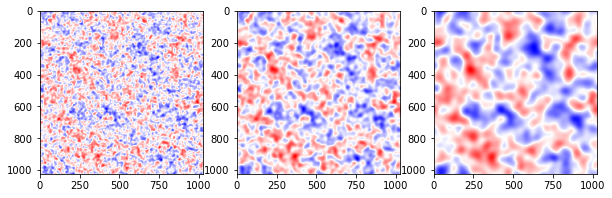

In [5]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=3)
for iR, R in enumerate((5, 10, 20)):
    axes[iR].imshow(ef.smooth(R), cmap='bwr')

Let's extract critical points now with a very large smoothing scale, so that we don't have many of them.

In [6]:
deltaR = ef.smooth(50)
extrema = ef.find_extrema(50).as_dataframe()  # get back a pandas dataframe

extrema.head()

,x,l1,h11,h12,y,l2,h22,kind,dens
0,6.731710,-0.000036,0.000034,-0.000017,110.113007,0.000038,-0.000032,1,-0.159222
1,8.763725,-0.000022,0.000007,0.000026,419.358432,0.000031,0.000001,1,0.102283
2,14.646337,-0.000024,-0.000014,0.000022,766.001275,0.000033,0.000023,1,-0.154370
3,22.604937,0.000040,0.000043,-0.000003,170.119318,0.000047,0.000044,2,-0.188131
4,25.794499,-0.000008,0.000014,-0.000019,552.161422,0.000031,0.000009,1,0.085138


The extrema are yielded back simply as a pandas dataframe.

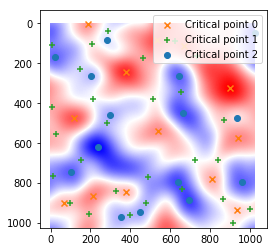

In [7]:
plt.imshow(deltaR.T, cmap='bwr')

cc = cycler(marker=['x', '+', 'o']) + cycler(color=['tab:orange', 'tab:green', 'tab:blue'])

for kind, style in zip(range(3), cc):
    ext = extrema[extrema.kind == kind]
    
    plt.scatter('x', 'y', data=ext, **style, label='Critical point %s' % kind)
plt.legend()

# Extracting critical events (critical point mergers)

Let's first build the extrema finder and the `slopping saddle` handler.

In [8]:
ef = ExtremaFinder(delta, cache_len=1, nthreads=4, boxlen=100)
ss = SloppingSaddle(ef, Rgrid=np.geomspace(1, 10, 10))

In [9]:
crit_events = ss.detect_extrema()

/home/ccc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/ccc/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/ccc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
crit_events.head()

,iR,kind,index,x,l1,h11,h12,y,l2,h22,dens,R,head
0,0,1,1158,838.538735,-0.000032,0.003191,-0.000950,7.008717,3.470870e-03,0.000248,-0.117969,10.24000,0.5
1,2,0,35,91.295923,-0.000952,-0.000760,0.000381,186.828631,6.626850e-07,-0.000191,0.106442,17.08135,0.5
2,0,0,1021,753.426995,-0.003823,-0.003313,0.001303,882.319712,1.296197e-05,-0.000498,0.224520,10.24000,0.5
3,0,1,551,413.108064,-0.000011,0.000963,0.000620,684.171401,1.358722e-03,0.000385,-0.187221,10.24000,0.5
4,0,0,1387,1004.718756,-0.002231,-0.001676,0.000953,298.250714,-4.169703e-05,-0.000597,0.324496,10.24000,0.5


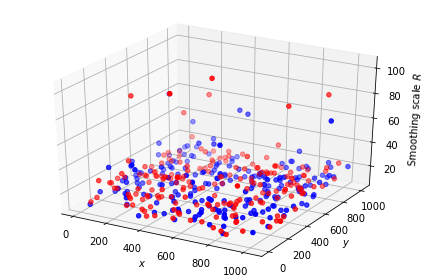

In [12]:
ax = plt.subplot(111, projection='3d')
cc = cycler(color=['red', 'blue'])
for kind, style in zip(range(2), cc):
    ce = crit_events[crit_events.kind == kind]
    ax.scatter3D(ce.x, ce.y, ce.R, **style)
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('Smoothing scale $R$')
plt.tight_layout()